# 1. Load Data

In [11]:
import warnings

import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score # get a specific score of a model using CV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a list of english stop words
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.exceptions import ConvergenceWarning

In [5]:
df = pd.read_csv("training.csv")
df.head()
df.shape

,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


(9500, 3)

In [19]:
# encode labels to integers 0-9
# creating instance of one-hot-encoder
df = df[df.topic!='IRRELEVANT']
data_x = df.article_words
data_y = df.topic

train_x,dev_x,train_y,dev_y = train_test_split(data_x,data_y,test_size = 0.1,shuffle=False)
y_train = LabelEncoder().fit_transform(train_y)
y_dev = LabelEncoder().fit_transform(dev_y)
categories=list(set(df['topic']))
print(categories)

['SCIENCE AND TECHNOLOGY', 'DOMESTIC MARKETS', 'SHARE LISTINGS', 'FOREX MARKETS', 'DEFENCE', 'SPORTS', 'HEALTH', 'BIOGRAPHIES PERSONALITIES PEOPLE', 'ARTS CULTURE ENTERTAINMENT', 'MONEY MARKETS']


# 2. Feature Engineering
## 2.1 as a Bag of Words(BoW)
Ignore shape of texts, focus on individual words (sometimes multiple words back to back)

- Tokenization
- Vocabulary building
    - **all** words that appear in **all** of the documents in the corpus, and number them (say, in alphabetic order)
- Encodeing
    - for each **document**, count how often each word in the vocabulary appear in this document:
        - 0 if not present
    
See the example below: adoped from the same chapter of the book
Screen Shot 2020-04-04 at 6.54.26 pm.png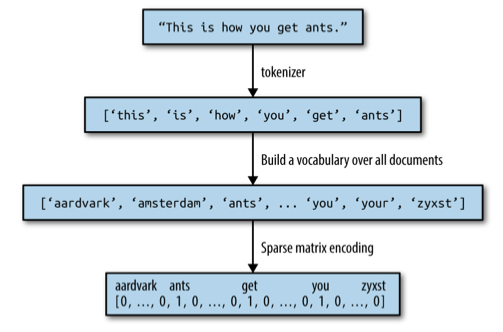

<div align="center">
    Process of BoW
</div>

In [15]:
vect = CountVectorizer().fit(train_x)

In [16]:
print(f"vocabulary size: {len(vect.vocabulary_)}")

vocabulary size: 23012


In [17]:
features = vect.get_feature_names()
print(f"The top 20 most frequent words:\n{features[:20]}")
print("\nFeatures 20010 to 20030:\n{}".format(features[20010:20030]))
print("\nEvery 2000th feature:\n{}".format(features[::2000]))

The top 20 most frequent words:
['_____', '______', '_______', '____________', '_bret', 'a1', 'a1b1', 'a2', 'a78', 'aa', 'aahp', 'aalborg', 'aalst', 'aalton', 'aaltonaa', 'aamir', 'aamodt', 'aandewiel', 'aaqib', 'aaquib']

Features 20010 to 20030:
['take', 'taked', 'takeoff', 'takeov', 'takesh', 'taku', 'takum', 'takuy', 'tal', 'talaj', 'talal', 'talanoa', 'talat', 'talbot', 'talc', 'tale', 'taleb', 'talent', 'talinv', 'talk']

Every 2000th feature:
['_____', 'berret', 'colob', 'egg', 'gnid', 'iser', 'lubric', 'niall', 'pretr', 'schoettel', 'tajik', 'vorobyov']


In [18]:
%%time
X_train = vect.transform(train_x)
print(f"X_train:\n {repr(X_train)}")
print(f"Type of X_train:\n {type(X_train)}")

X_train:
 <4289x23012 sparse matrix of type '<class 'numpy.int64'>'
	with 351519 stored elements in Compressed Sparse Row format>
Type of X_train:
 <class 'scipy.sparse.csr.csr_matrix'>
CPU times: user 466 ms, sys: 7.7 ms, total: 474 ms
Wall time: 476 ms


## 2.2 Try to fit a model
We can observe several potential problems on the first glance:
1. the top 20 words are numbers! And most of them seemingly meaningless, except perhaps '007'. 
2. different parts of speech (noun, verb, adj...) or tenses (present, past...) of a word are considered distinct
3. singular and plural forms of a word are considered distinct

<font color='blue'>It is difficult but necessary to filter our feature extraction, more on that later.</font>

For now, let’s obtain a quantitative measure of performance by actually building a classifier.

### 2.2.1 logistic regression
The data matrix is now very **high dimensional** (23012 features), and **sparse** (most values in the matrix X_train are 0). For dataset like this, linear models like `LogisticRegression` often work best.

In [20]:
# Ingore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Get accuracy scores for each of 5-fold CV
# b_jobs specifies how many processors are used in paralle, -1 means all
accs = cross_val_score(LogisticRegression(n_jobs=-1), X_train, y_train, cv=5)
print(f"Accuracy scores: {accs}")
print(f"Mean (5-fold CV) accuracy: {np.mean(accs): .3f}")

Accuracy scores: [0.76107226 0.76340326 0.77855478 0.74475524 0.77012835]
Mean (5-fold CV) accuracy:  0.764


### 2.2.2 Tune the model
0.88 is a reasonable performance for a balanced binary classification task.

We know that logistic regression has a regularization term $C\sum_{i=1}^{D}\lambda_i^2$ (l2 regularization), and 'C' is a parameter we can optimize here.

C = \[0.001, 0.01, 0.1, 1.0, 10.0\], (C=1.0 by LogisticRegression default)

In [21]:
param_grid = {'C': np.geomspace(0.001,10,num=5,endpoint=True)}
param_grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}

In [22]:
%%time
grid = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

CPU times: user 403 ms, sys: 239 ms, total: 643 ms
Wall time: 1min 42s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
print(f"best parameter: {grid.best_params_}")
print(f"best 5-fold CV score (accuracy): {grid.best_score_: .3f}")

best parameter: {'C': 10.0}
best 5-fold CV score (accuracy):  0.772


### 2.2.3 Test on test set
GridSearchCV by default <font color='blue'>**refit**</font> the model passed in with best parameters, and can be used directly on test sets.

In [25]:
%%time
X_dev = vect.transform(dev_x)
acc_dev = grid.score(X_dev, y_dev)
print(f"Logistic regression accuracy on dev set: {acc_dev:.2f}")

Logistic regression accuracy on dev set: 0.76
CPU times: user 78.8 ms, sys: 3.35 ms, total: 82.1 ms
Wall time: 87.8 ms


## 2.3 Improve the feature extraction
CounterVectorizer extacts tokens use `r"\b\w\w+\b"` which means 2 or more conscecutive characters between two word boundaries `("\'", ',', '_', '.', ' ', '-' ...)`

### 2.3.1 Set a minimum number of documents a token needs to be appear in, with the `min_df` parameter, in order to be considered as a feature.

In [27]:
%%time
vect_1 = CountVectorizer(min_df=5).fit(train_x)
X_train_1 = vect_1.transform(train_x)

print(f"X_train:\n {repr(X_train)}")
print(f"X_train with min_df=5:\n {repr(X_train_1)}")

X_train:
 <4289x23012 sparse matrix of type '<class 'numpy.int64'>'
	with 351519 stored elements in Compressed Sparse Row format>
X_train with min_df=5:
 <4289x6362 sparse matrix of type '<class 'numpy.int64'>'
	with 325351 stored elements in Compressed Sparse Row format>
CPU times: user 1.23 s, sys: 45.9 ms, total: 1.28 s
Wall time: 1.39 s


In [28]:
features_1 = vect.get_feature_names()
print("First 50 features:\n{}".format(features_1[:50])) 
print("\nFeatures 20010 to 20030:\n{}".format(features_1[20010:20030])) 
print("\nEvery 700th feature:\n{}".format(features_1[::700]))

First 50 features:
['_____', '______', '_______', '____________', '_bret', 'a1', 'a1b1', 'a2', 'a78', 'aa', 'aahp', 'aalborg', 'aalst', 'aalton', 'aaltonaa', 'aamir', 'aamodt', 'aandewiel', 'aaqib', 'aaquib', 'aardvark', 'aargau', 'aarhus', 'aaron', 'aash', 'ab', 'abab', 'abach', 'aback', 'abandon', 'abat', 'abattoir', 'abax', 'abay', 'abb', 'abba', 'abbey', 'abbot', 'abbrev', 'abc', 'abciximab', 'abcp', 'abdal', 'abdel', 'abdelwahhab', 'abderrahim', 'abdicat', 'abdom', 'abdomin', 'abduc']

Features 20010 to 20030:
['take', 'taked', 'takeoff', 'takeov', 'takesh', 'taku', 'takum', 'takuy', 'tal', 'talaj', 'talal', 'talanoa', 'talat', 'talbot', 'talc', 'tale', 'taleb', 'talent', 'talinv', 'talk']

Every 700th feature:
['_____', 'amr', 'azeglio', 'bibby', 'bubor', 'chant', 'constrict', 'deceb', 'dosek', 'eoe', 'filmmak', 'gastr', 'gun', 'hold', 'instit', 'kadir', 'kwok', 'lola', 'matterhorn', 'mojc', 'niall', 'otmar', 'petersburg', 'proj', 'rehabilit', 'ruan', 'semiannual', 'sobhraj', 'su

### 2.3.2 Train the model again

In [29]:
%%time
grid = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid, cv=5) 
grid.fit(X_train_1, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.77
Best parameters: {'C': 10.0}
CPU times: user 410 ms, sys: 224 ms, total: 635 ms
Wall time: 1min 2s


In [30]:
X_test_1 = vect_1.transform(dev_x)
acc_test = grid.score(X_test_1, y_dev)
print(f"Logistic regression accuracy on test set: {acc_test:.2f}")

Logistic regression accuracy on test set: 0.75


## 2.4 Stopwords
Another way of getting rid of uninformative words (too frequent).

`scikit-learn` has a built-in list of Engish stop words in the `feature_extraction.text` module:

In [31]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['much', 'about', 'somewhere', 'over', 'my', 'she', 'here', 'cant', 'might', 'found', 'too', 'enough', 'anyhow', 'except', 'as', 'down', 'besides', 'although', 'never', 'hereafter', 're', 'no', 'me', 'since', 'should', 'almost', 'made', 'co', 'nevertheless', 'two', 'nor', 'through']


In [32]:
%%time
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect_2 = CountVectorizer(min_df=5, stop_words="english").fit(train_x)
X_train_2 = vect_2.transform(train_x)
print("X_train with min_df=5 and stop words:\n{}".format(repr(X_train_2)))

X_train with min_df=5 and stop words:
<4289x6295 sparse matrix of type '<class 'numpy.int64'>'
	with 315123 stored elements in Compressed Sparse Row format>
CPU times: user 1.48 s, sys: 58.9 ms, total: 1.53 s
Wall time: 1.85 s


In [33]:
%%time
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_2, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.77
CPU times: user 1min 18s, sys: 2.28 s, total: 1min 20s
Wall time: 46.7 s
